In [1]:
import scanpy as sc
import anndata as an
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl

sc.set_figure_params(dpi_save=300,color_map = 'viridis_r')
sc.settings.verbosity = 1
sc.logging.print_header()

from sklearn.neighbors import NearestNeighbors
import time
from tqdm import tqdm
import sys
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.cluster import MiniBatchKMeans
import seaborn as sns

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
/data/person/lab/fengcz/conda/envs/squidpy/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-11-21 16:40:38.043390: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-21 16:40:38.167141: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-11-21 16:40:38.206766: E e

scanpy==1.9.3 anndata==0.9.2 umap==0.5.3 numpy==1.25.2 scipy==1.11.4 pandas==1.3.5 scikit-learn==1.2.1 statsmodels==0.14.0 python-igraph==0.10.2 pynndescent==0.5.7


# Read cell2location estimates

In [4]:
adata = sc.read('../../decoupler_tumor_subtypes/spatial_c2l_with_tumor_subtypes.h5ad')
adata

AnnData object with n_obs × n_vars = 2102308 × 16147
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'Patient', 'Sample', 'Site', 'X_center', 'Y_center', 'n_counts', '_indices', '_scvi_batch', '_scvi_labels', 'CD4+ T', 'CD8+ T', 'DC', 'Endothelial cells', 'Epithelial cells', 'Fibroblasts', 'M1-like', 'NK', 'Pericytes', 'Plasma cells', 'Macros MRC1', 'Macros SPP1', 'Treg', 'myCAF MMP11+', 'myCAF MMP11-', 'Cell_type_refined', 'Pan-epi', 'Cycling epi', 'Immunoreactive epi', 'Hypoxia epi', 'Normal secretory epi', 'EMT epi'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'log1p', 'mod'
    obsm: 'MT', 'means_cell_abundance_w_sf', 'q05_cell_abundance_w_sf', 'q95_cell_abundance_w_sf', 'spatial', 'stds_cell_abundance_w_sf'

In [5]:
spatial_clone = pd.read_csv('../01.infercnv/window100/P6_YF_1/spatial_clone.csv',index_col=0)
spatial_clone

,sample,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,total_counts_mt,...,Chr3,Chr4,Chr5,Chr6,Chr7,Chr8,Chr9,ChrX,leiden,Spatial_clone
P6_YF_1_0_2550,P6_YF_1,649,6.476972,1316,7.183112,33.282675,45.820669,62.993921,88.677812,129,...,0.994423,1.000000,0.977685,0.979575,1.000000,1.006528,1.007077,1.000000,0,clone_2
P6_YF_1_0_3250,P6_YF_1,779,6.659294,1567,7.357556,28.525846,40.523293,56.604978,82.195278,193,...,1.000000,1.000000,1.005395,1.012372,1.000000,1.000000,1.014057,1.000000,0,clone_2
P6_YF_1_0_3300,P6_YF_1,830,6.722630,1659,7.414573,29.415310,40.807715,55.696203,80.108499,177,...,1.000000,1.000000,1.001439,0.981547,0.999833,0.995762,1.000000,1.032245,0,clone_2
P6_YF_1_0_3450,P6_YF_1,924,6.829794,1847,7.521859,27.612344,39.144559,53.654575,77.043855,192,...,1.000000,0.986485,1.000000,0.972216,1.001147,1.010102,1.000000,1.022434,0,clone_2
P6_YF_1_0_3650,P6_YF_1,1036,6.944087,2257,7.722235,27.647319,37.837838,52.547630,76.251661,208,...,1.001297,0.992897,0.979463,0.983966,1.003766,0.995466,1.003283,1.006506,0,clone_2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P6_YF_1_5000_12150,P6_YF_1,89,4.499810,150,5.017280,74.000000,100.000000,100.000000,100.000000,34,...,1.000000,1.000000,0.991520,0.998093,1.000000,1.000000,1.000000,1.011182,1,clone_1
P6_YF_1_13300_16300,P6_YF_1,101,4.624973,141,4.955827,63.829787,99.290780,100.000000,100.000000,18,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.012127,1.000000,0.996323,1,clone_1
P6_YF_1_13950_14900,P6_YF_1,238,5.476464,319,5.768321,37.931034,56.739812,88.087774,100.000000,15,...,1.000000,0.993064,0.994071,1.005022,1.014703,1.000000,1.013991,1.000000,1,clone_1
P6_YF_1_10200_11500,P6_YF_1,96,4.574711,139,4.941642,66.906475,100.000000,100.000000,100.000000,4,...,1.012910,1.000000,1.029794,1.006616,1.012689,1.001031,1.000000,1.000000,1,clone_1


In [6]:
adata = adata[spatial_clone.index,].copy()
adata

AnnData object with n_obs × n_vars = 87842 × 16147
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'Patient', 'Sample', 'Site', 'X_center', 'Y_center', 'n_counts', '_indices', '_scvi_batch', '_scvi_labels', 'CD4+ T', 'CD8+ T', 'DC', 'Endothelial cells', 'Epithelial cells', 'Fibroblasts', 'M1-like', 'NK', 'Pericytes', 'Plasma cells', 'Macros MRC1', 'Macros SPP1', 'Treg', 'myCAF MMP11+', 'myCAF MMP11-', 'Cell_type_refined', 'Pan-epi', 'Cycling epi', 'Immunoreactive epi', 'Hypoxia epi', 'Normal secretory epi', 'EMT epi'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'log1p', 'mod'
    obsm: 'MT', 'means_cell_abundance_w_sf', 'q05_cell_abundance_w_sf', 'q95_cell_abundance_w_sf', 'spatial', 'stds_cell_abundance_w_sf'

In [7]:
adata.obs['Spatial_clone'] = spatial_clone.Spatial_clone
adata

AnnData object with n_obs × n_vars = 87842 × 16147
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'Patient', 'Sample', 'Site', 'X_center', 'Y_center', 'n_counts', '_indices', '_scvi_batch', '_scvi_labels', 'CD4+ T', 'CD8+ T', 'DC', 'Endothelial cells', 'Epithelial cells', 'Fibroblasts', 'M1-like', 'NK', 'Pericytes', 'Plasma cells', 'Macros MRC1', 'Macros SPP1', 'Treg', 'myCAF MMP11+', 'myCAF MMP11-', 'Cell_type_refined', 'Pan-epi', 'Cycling epi', 'Immunoreactive epi', 'Hypoxia epi', 'Normal secretory epi', 'EMT epi', 'Spatial_clone'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'log1p', 'mod'
    obsm: 'MT', 'means_cell_abundance_w_sf', 'q05_cell_abundance_w_sf', 'q95_cell_abundance_w_sf', 'spatial', 'stds_cell_abundance_w_sf'

In [8]:
adata.obs.Cell_type_refined.value_counts()

Epithelial cells     51157
Fibroblasts          16216
Pericytes             6639
Endothelial cells     6596
myCAF MMP11+          2534
myCAF MMP11-          1108
Macros MRC1            766
M1-like                676
DC                     589
Plasma cells           472
Macros SPP1            391
Treg                   293
NK                     206
CD4+ T                 161
CD8+ T                  38
Name: Cell_type_refined, dtype: int64

# Filter spots

In [9]:
adata = adata[adata.obs.Cell_type_refined=='Epithelial cells',].copy()
adata

AnnData object with n_obs × n_vars = 51157 × 16147
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'Patient', 'Sample', 'Site', 'X_center', 'Y_center', 'n_counts', '_indices', '_scvi_batch', '_scvi_labels', 'CD4+ T', 'CD8+ T', 'DC', 'Endothelial cells', 'Epithelial cells', 'Fibroblasts', 'M1-like', 'NK', 'Pericytes', 'Plasma cells', 'Macros MRC1', 'Macros SPP1', 'Treg', 'myCAF MMP11+', 'myCAF MMP11-', 'Cell_type_refined', 'Pan-epi', 'Cycling epi', 'Immunoreactive epi', 'Hypoxia epi', 'Normal secretory epi', 'EMT epi', 'Spatial_clone'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'log1p', 'mod'
    obsm: 'MT', 'means_cell_abundance_w_sf', 'q05_cell_abundance_w_sf', 'q95_cell_abundance_w_sf', 'spatial', 'stds_cell_abundance_w_sf'

In [10]:
adata.obs.Spatial_clone.value_counts()

clone_2    30620
clone_3    14515
clone_1     6022
Name: Spatial_clone, dtype: int64

In [11]:
adata = adata[adata.obs.Spatial_clone!='clone_1',].copy()
adata

AnnData object with n_obs × n_vars = 45135 × 16147
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'Patient', 'Sample', 'Site', 'X_center', 'Y_center', 'n_counts', '_indices', '_scvi_batch', '_scvi_labels', 'CD4+ T', 'CD8+ T', 'DC', 'Endothelial cells', 'Epithelial cells', 'Fibroblasts', 'M1-like', 'NK', 'Pericytes', 'Plasma cells', 'Macros MRC1', 'Macros SPP1', 'Treg', 'myCAF MMP11+', 'myCAF MMP11-', 'Cell_type_refined', 'Pan-epi', 'Cycling epi', 'Immunoreactive epi', 'Hypoxia epi', 'Normal secretory epi', 'EMT epi', 'Spatial_clone'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'log1p', 'mod'
    obsm: 'MT', 'means_cell_abundance_w_sf', 'q05_cell_abundance_w_sf', 'q95_cell_abundance_w_sf', 'spatial', 'stds_cell_abundance_w_sf'

In [12]:
adata.obs['purity'] = adata.obs['Epithelial cells']/adata.obs[['CD4+ T', 'CD8+ T', 'DC', 'Endothelial cells', 'Epithelial cells', 'Fibroblasts', 
           'M1-like', 'NK', 'Pericytes', 'Plasma cells', 'Macros MRC1', 'Macros SPP1', 
           'Treg', 'myCAF MMP11+', 'myCAF MMP11-']].sum(axis=1)

In [13]:
adata = adata[adata.obs.purity>0.1,].copy()
adata

AnnData object with n_obs × n_vars = 45134 × 16147
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'Patient', 'Sample', 'Site', 'X_center', 'Y_center', 'n_counts', '_indices', '_scvi_batch', '_scvi_labels', 'CD4+ T', 'CD8+ T', 'DC', 'Endothelial cells', 'Epithelial cells', 'Fibroblasts', 'M1-like', 'NK', 'Pericytes', 'Plasma cells', 'Macros MRC1', 'Macros SPP1', 'Treg', 'myCAF MMP11+', 'myCAF MMP11-', 'Cell_type_refined', 'Pan-epi', 'Cycling epi', 'Immunoreactive epi', 'Hypoxia epi', 'Normal secretory epi', 'EMT epi', 'Spatial_clone', 'purity'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'log1p', 'mod'
    obsm: 'MT', 'means_cell_abundance_w_sf', 'q05_cell_abundance_w_sf', 'q95_cell_abundance_w_sf', 'spatial', 'stds_cell_abundance_w_sf'

In [14]:
adata.obs.Sample.value_counts()

P6_YF_1    45134
Name: Sample, dtype: int64

# Calculate observed

In [15]:
cells=adata.obs.copy()
cells["spot_ID"]=adata.obs_names
cells.index=range(len(cells.index))
cells[['X_center','Y_center',"Spatial_clone","spot_ID"]]
# cells=cells.drop(['CD4+ T', 'CD8+ T', 'DC', 'Endothelial cells', 'Epithelial cells', 
#                   'Fibroblasts', 'M1-like', 'NK', 'Pericytes', 'Plasma cells', 
#                   'Macros MRC1', 'Macros SPP1', 'Treg', 'myCAF MMP11+', 'myCAF MMP11-' ],axis=1)
cells.head()

,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,total_counts_mt,pct_counts_mt,...,Cell_type_refined,Pan-epi,Cycling epi,Immunoreactive epi,Hypoxia epi,Normal secretory epi,EMT epi,Spatial_clone,purity,spot_ID
0,779,6.659294,1567,7.357556,28.525846,40.523293,56.604978,82.195278,193,12.316528,...,Epithelial cells,0.553251,0.209567,0.316045,0.253856,0.100411,0.352344,clone_2,0.302262,P6_YF_1_0_3250
1,830,6.722630,1659,7.414573,29.415310,40.807715,55.696203,80.108499,177,10.669078,...,Epithelial cells,0.648573,0.246390,0.253280,0.409124,0.097333,0.365408,clone_2,0.175790,P6_YF_1_0_3300
2,924,6.829794,1847,7.521859,27.612344,39.144559,53.654575,77.043855,192,10.395236,...,Epithelial cells,0.579501,0.219283,0.283595,0.313302,0.134932,0.538063,clone_2,0.234658,P6_YF_1_0_3450
3,1036,6.944087,2257,7.722235,27.647319,37.837838,52.547630,76.251661,208,9.215773,...,Epithelial cells,0.644943,0.236736,0.333517,0.433543,0.144696,0.416159,clone_2,0.315539,P6_YF_1_0_3650
4,1109,7.012115,2339,7.757906,26.464301,35.955537,49.465584,73.963232,227,9.705002,...,Epithelial cells,0.691519,0.235645,0.307296,0.393469,0.160629,0.494586,clone_2,0.320879,P6_YF_1_0_3750


# The following codes are re-organized from 'Coordinated Cellular Neighborhoods Orchestrate Antitumoral Immunity at the Colorectal Cancer Invasive Front', Cell, 2020
## Fill In:
    -ks = individual window sizes to collect.  
        -This accelerates the process of trying different window sizes by collecting them all in one step.
    -path_to_data:  file path for csv file with x,y cluster information
    -X:  column to use for X location
    -Y:  column to use for Y location
    -reg:  column to use for region (should be different for every tissue)
    -file_type('csv','pickle'):  file type
    -cluster_col : column name of cell type cluster to be used for neighborhoods
    -cellhierpath:  path to cellhier libary (should only have to set once per computer
    -keep_cols:  columns to transfer from original dataframe to dataframe with windows and neighborhoods

In [19]:
def calculate_score(
    df,
    ks = [5,10,20,100],
    X = 'X_center',
    Y = 'Y_center',
    reg = 'Sample',
    cluster_col = 'Spatial_clone'
):
    def get_windows(job,n_neighbors):
        '''
        For each region and each individual cell in dataset, return the indices of the nearest neighbors.

        'job:  meta data containing the start time,index of region, region name, indices of region in original dataframe
        n_neighbors:  the number of neighbors to find for each cell
        '''
        start_time,idx,tissue_name,indices = job
        job_start = time.time()

        # print ("Starting:", str(idx+1)+'/'+str(len(exps)),': ' + exps[idx])

        tissue = tissue_group.get_group(tissue_name)
        to_fit = tissue.loc[indices][[X,Y]].values

    #     fit = NearestNeighbors(n_neighbors=n_neighbors+1).fit(tissue[[X,Y]].values)
        fit = NearestNeighbors(n_neighbors=n_neighbors).fit(tissue[[X,Y]].values)
        m = fit.kneighbors(to_fit)
    #     m = m[0][:,1:], m[1][:,1:]
        m = m[0], m[1]


        #sort_neighbors
        args = m[0].argsort(axis = 1)
        add = np.arange(m[1].shape[0])*m[1].shape[1]
        sorted_indices = m[1].flatten()[args+add[:,None]]

        neighbors = tissue.index.values[sorted_indices]

        end_time = time.time()

        # print ("Finishing:", str(idx+1)+"/"+str(len(exps)),": "+ exps[idx],end_time-job_start,end_time-start_time)
        return neighbors.astype(np.int32)
    keep_cols = [X,Y,reg,cluster_col]
    
    #read in data and do some quick data rearrangement
    n_neighbors = max(ks)

    # assert (file_type=='csv' or file_type =='pickle') #


    # if file_type == 'pickle':
    #     cells = pd.read_pickle(path_to_data)
    # if file_type == 'csv':
    #     cells = pd.read_csv(path_to_data)

    cells2 = pd.concat([df,pd.get_dummies(df[cluster_col])],1)


    sum_cols = np.array(cells2[cluster_col].unique())
    values = cells2[sum_cols].values
    
    #find windows for each cell in each tissue region
    tissue_group = cells2[[X,Y,reg]].groupby(reg)
    exps = list(cells2[reg].unique())
    tissue_chunks = [(time.time(),exps.index(t),t,a) for t,indices in tissue_group.groups.items() for a in np.array_split(indices,1)] 
    tissues = [get_windows(job,n_neighbors) for job in tissue_chunks]
    
    #for each cell and its nearest neighbors, reshape and count the number of each cell type in those neighbors.
    out_dict = {}
    for k in ks:
        for neighbors,job in zip(tissues,tissue_chunks):

            chunk = np.arange(len(neighbors))#indices
            tissue_name = job[2]
            indices = job[3]
            window = values[neighbors[chunk,:k].flatten()].reshape(len(chunk),k,len(sum_cols)).sum(axis = 1)
            out_dict[(tissue_name,k)] = (window.astype(np.float16),indices)
            
    #concatenate the summed windows and combine into one dataframe for each window size tested.
    windows = {}
    for k in ks:

        window = pd.concat([pd.DataFrame(out_dict[(exp,k)][0],index = out_dict[(exp,k)][1].astype(int),columns = sum_cols) for exp in exps],0)
        window = window.loc[cells2.index.values]
        window = pd.concat([cells2[keep_cols],window],1)
        windows[k] = window
        
    for k in ks:
        windows_select = windows[k]

        count = [windows_select.loc[index,windows_select.Spatial_clone[index]]  for index in windows_select.index]
        observed = np.array(count)/k
        
        pd.DataFrame(observed,index=cells2["spot_ID"]).to_csv(f'observed_windows/windows_{k}_observed.csv')

In [20]:
calculate_score(
    cells,
    ks = [5,10,20,100],
    X = 'X_center',
    Y = 'Y_center',
    reg = 'Sample',
    cluster_col = 'Spatial_clone'
)

/tmp/ipykernel_61465/1911533343.py:55: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  cells2 = pd.concat([df,pd.get_dummies(df[cluster_col])],1)
/tmp/ipykernel_61465/1911533343.py:82: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  window = pd.concat([pd.DataFrame(out_dict[(exp,k)][0],index = out_dict[(exp,k)][1].astype(int),columns = sum_cols) for exp in exps],0)
/tmp/ipykernel_61465/1911533343.py:84: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  window = pd.concat([cells2[keep_cols],window],1)


In [21]:
windows10_observed = pd.read_csv('./observed_windows/windows_10_observed.csv')
windows10_observed

,spot_ID,0
0,P6_YF_1_0_3250,1.0
1,P6_YF_1_0_3300,1.0
2,P6_YF_1_0_3450,1.0
3,P6_YF_1_0_3650,1.0
4,P6_YF_1_0_3750,1.0
...,...,...
45129,P6_YF_1_4550_5400,0.3
45130,P6_YF_1_13350_13950,0.9
45131,P6_YF_1_5250_12050,0.4
45132,P6_YF_1_15400_14050,1.0


In [22]:
cells[['X_center','Y_center',"Spatial_clone","spot_ID",'Sample']]

,X_center,Y_center,Spatial_clone,spot_ID,Sample
0,0,4050,clone_2,P6_YF_1_0_3250,P6_YF_1
1,0,4100,clone_2,P6_YF_1_0_3300,P6_YF_1
2,0,4250,clone_2,P6_YF_1_0_3450,P6_YF_1
3,0,4450,clone_2,P6_YF_1_0_3650,P6_YF_1
4,0,4550,clone_2,P6_YF_1_0_3750,P6_YF_1
...,...,...,...,...,...
45129,4550,6200,clone_2,P6_YF_1_4550_5400,P6_YF_1
45130,13350,14750,clone_2,P6_YF_1_13350_13950,P6_YF_1
45131,5250,12850,clone_2,P6_YF_1_5250_12050,P6_YF_1
45132,15400,14850,clone_2,P6_YF_1_15400_14050,P6_YF_1


# Calculate random shuffled

In [23]:
def shuffle_samplewise(sample,seed=0):
    cells_subset = cells.loc[cells.Sample==sample,:].copy()
    
    cells_subset = pd.concat([
        cells_subset[["Spatial_clone","spot_ID",'Sample']].set_index("spot_ID"),
        cells_subset.sample(frac=1,replace=False,random_state=seed,axis=0).set_index("spot_ID")[['X_center','Y_center']]
                             ],axis=1).reset_index()
    
    cells_subset['seed'] = seed
    
    return(cells_subset)



In [24]:
shuffle_df_list = [shuffle_samplewise(sample,seed) for sample in tqdm(cells.Sample.unique()) for seed in np.arange(100)]

100%|██████████| 1/1 [00:02<00:00,  2.99s/it]


In [25]:
shuffle_df_all = pd.concat(shuffle_df_list).reset_index()
shuffle_df_all

,index,spot_ID,Spatial_clone,Sample,X_center,Y_center,seed
0,0,P6_YF_1_0_3250,clone_2,P6_YF_1,0,4050,0
1,1,P6_YF_1_0_3300,clone_2,P6_YF_1,0,4100,0
2,2,P6_YF_1_0_3450,clone_2,P6_YF_1,0,4250,0
3,3,P6_YF_1_0_3650,clone_2,P6_YF_1,0,4450,0
4,4,P6_YF_1_0_3750,clone_2,P6_YF_1,0,4550,0
...,...,...,...,...,...,...,...
4513395,45129,P6_YF_1_4550_5400,clone_2,P6_YF_1,4550,6200,99
4513396,45130,P6_YF_1_13350_13950,clone_2,P6_YF_1,13350,14750,99
4513397,45131,P6_YF_1_5250_12050,clone_2,P6_YF_1,5250,12850,99
4513398,45132,P6_YF_1_15400_14050,clone_2,P6_YF_1,15400,14850,99


In [26]:
def calculate_score_expected(
    df,
    ks = [5,10,20,100],
    X = 'X_center',
    Y = 'Y_center',
    reg = 'Sample',
    cluster_col = 'Spatial_clone'
):
    def get_windows(job,n_neighbors):
        '''
        For each region and each individual cell in dataset, return the indices of the nearest neighbors.

        'job:  meta data containing the start time,index of region, region name, indices of region in original dataframe
        n_neighbors:  the number of neighbors to find for each cell
        '''
        start_time,idx,tissue_name,indices = job
        job_start = time.time()

        # print ("Starting:", str(idx+1)+'/'+str(len(exps)),': ' + exps[idx])

        tissue = tissue_group.get_group(tissue_name)
        to_fit = tissue.loc[indices][[X,Y]].values

    #     fit = NearestNeighbors(n_neighbors=n_neighbors+1).fit(tissue[[X,Y]].values)
        fit = NearestNeighbors(n_neighbors=n_neighbors).fit(tissue[[X,Y]].values)
        m = fit.kneighbors(to_fit)
    #     m = m[0][:,1:], m[1][:,1:]
        m = m[0], m[1]


        #sort_neighbors
        args = m[0].argsort(axis = 1)
        add = np.arange(m[1].shape[0])*m[1].shape[1]
        sorted_indices = m[1].flatten()[args+add[:,None]]

        neighbors = tissue.index.values[sorted_indices]

        end_time = time.time()

        # print ("Finishing:", str(idx+1)+"/"+str(len(exps)),": "+ exps[idx],end_time-job_start,end_time-start_time)
        return neighbors.astype(np.int32)
    
    keep_cols = [X,Y,reg,cluster_col]
    
    #read in data and do some quick data rearrangement
    n_neighbors = max(ks)

    # assert (file_type=='csv' or file_type =='pickle') #


    # if file_type == 'pickle':
    #     cells = pd.read_pickle(path_to_data)
    # if file_type == 'csv':
    #     cells = pd.read_csv(path_to_data)

    cells2 = pd.concat([df,pd.get_dummies(df[cluster_col])],1)


    sum_cols = np.array(cells2[cluster_col].unique())
    values = cells2[sum_cols].values
    
    #find windows for each cell in each tissue region
    tissue_group = cells2[[X,Y,reg]].groupby(reg)
    exps = list(cells2[reg].unique())
    tissue_chunks = [(time.time(),exps.index(t),t,a) for t,indices in tissue_group.groups.items() for a in np.array_split(indices,1)] 
    tissues = [get_windows(job,n_neighbors) for job in tissue_chunks]
    
    #for each cell and its nearest neighbors, reshape and count the number of each cell type in those neighbors.
    out_dict = {}
    for k in ks:
        for neighbors,job in zip(tissues,tissue_chunks):

            chunk = np.arange(len(neighbors))#indices
            tissue_name = job[2]
            indices = job[3]
            window = values[neighbors[chunk,:k].flatten()].reshape(len(chunk),k,len(sum_cols)).sum(axis = 1)
            out_dict[(tissue_name,k)] = (window.astype(np.float16),indices)
            
    #concatenate the summed windows and combine into one dataframe for each window size tested.
    windows = {}
    for k in ks:

        window = pd.concat([pd.DataFrame(out_dict[(exp,k)][0],index = out_dict[(exp,k)][1].astype(int),columns = sum_cols) for exp in exps],0)
        window = window.loc[cells2.index.values]
        window = pd.concat([cells2[keep_cols],window],1)
        windows[k] = window
        
    for k in ks:
        windows_select = windows[k]

        count = [windows_select.loc[index,windows_select.Spatial_clone[index]]  for index in windows_select.index]
        observed = np.array(count)/k

        pd.DataFrame(observed,index=cells2["spot_ID"]).to_csv(f'expected_windows//windows_{k}_seed{df.seed[0]}.csv')


def calculate_expected_min_seedwise(df,seed):
    df_subset = df.loc[df.seed==seed,:].copy()
    df_subset = df_subset.reset_index()
    df_subset.Sample = df_subset.Sample.astype(str)
    expected_score = calculate_score_expected(
        df_subset,
        ks = [5,10,20,100],
        X = 'X_center',
        Y = 'Y_center',
        reg = 'Sample',
        cluster_col = 'Spatial_clone'
    )
    
    
    return(expected_score)

In [27]:
shuffle_score_list = [calculate_expected_min_seedwise(shuffle_df_all,seed) for seed in tqdm(np.arange(100))]

  0%|          | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_61465/1458290100.py:56: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  cells2 = pd.concat([df,pd.get_dummies(df[cluster_col])],1)
/tmp/ipykernel_61465/1458290100.py:83: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  window = pd.concat([pd.DataFrame(out_dict[(exp,k)][0],index = out_dict[(exp,k)][1].astype(int),columns = sum_cols) for exp in exps],0)
/tmp/ipykernel_61465/1458290100.py:85: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  window = pd.concat([cells2[keep_cols],window],1)
  1%|          | 1/100 [00:03<04:57,  3.00s/it]/tmp/ipykernel_61465/1458290100.py:56: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  cells2 = pd.concat([df,

In [28]:
def calculate_scaled_coherence_score(window):
    expected_windows_selected = pd.concat([pd.read_csv(f'./expected_windows/windows_{window}_seed{seed}.csv') for seed in tqdm(np.arange(100))])
    expected_windows_selected_merged = pd.merge(expected_windows_selected,cells[['spot_ID','Sample']],how='left',on=['spot_ID','spot_ID'])
    expected_windows_selected_mean = expected_windows_selected_merged.groupby('Sample')['0'].mean()
    
    observed_windows_selected = pd.read_csv(f'./observed_windows/windows_{window}_observed.csv')
    observed_windows_selected_merged = pd.merge(observed_windows_selected,cells[['spot_ID','Sample']],how='left',on=['spot_ID','spot_ID'])
    observed_windows_selected_merged = pd.merge(observed_windows_selected_merged,pd.DataFrame(expected_windows_selected_mean).reset_index(),how = 'left',on=['Sample','Sample'])
    observed_windows_selected_merged['coherence'] = (observed_windows_selected_merged['0_x']-observed_windows_selected_merged['0_y'])/(1-observed_windows_selected_merged['0_y'])
    observed_windows_selected_merged.loc[observed_windows_selected_merged['coherence']>1,'coherence']=1.0
    observed_windows_selected_merged.loc[observed_windows_selected_merged['coherence']<0,'coherence']=0
    
    observed_windows_selected_merged['Window']=window
    
    return(observed_windows_selected_merged)

In [29]:
scaled_coherence_score_list = [calculate_scaled_coherence_score(window) for window in [5,10,20,100]]

100%|██████████| 100/100 [00:01<00:00, 77.80it/s]


In [30]:
scaled_coherence_score = pd.concat(scaled_coherence_score_list)
scaled_coherence_score.to_csv('scaled_coherence_score.csv')

In [31]:
scaled_coherence_score = pd.read_csv('scaled_coherence_score.csv',index_col=0)
scaled_coherence_score.head()

,spot_ID,0_x,Sample,0_y,coherence,Window
0,P6_YF_1_0_3250,1.0,P6_YF_1,0.847051,1.0,5
1,P6_YF_1_0_3300,1.0,P6_YF_1,0.847051,1.0,5
2,P6_YF_1_0_3450,1.0,P6_YF_1,0.847051,1.0,5
3,P6_YF_1_0_3650,1.0,P6_YF_1,0.847051,1.0,5
4,P6_YF_1_0_3750,1.0,P6_YF_1,0.847051,1.0,5


In [32]:
adata.obs = pd.merge(adata.obs,scaled_coherence_score.loc[scaled_coherence_score['Window']==5,['spot_ID','coherence']],how='left',left_index=True,right_on=['spot_ID']).set_index('spot_ID')
adata.obs = pd.merge(adata.obs,scaled_coherence_score.loc[scaled_coherence_score['Window']==10,['spot_ID','coherence']],how='left',left_index=True,right_on=['spot_ID']).set_index('spot_ID')
adata.obs = pd.merge(adata.obs,scaled_coherence_score.loc[scaled_coherence_score['Window']==20,['spot_ID','coherence']],how='left',left_index=True,right_on=['spot_ID']).set_index('spot_ID')
adata.obs = pd.merge(adata.obs,scaled_coherence_score.loc[scaled_coherence_score['Window']==100,['spot_ID','coherence']],how='left',left_index=True,right_on=['spot_ID']).set_index('spot_ID')

/tmp/ipykernel_61465/3468656068.py:4: FutureWarning: Passing 'suffixes' which cause duplicate columns {'coherence_x'} in the result is deprecated and will raise a MergeError in a future version.
  adata.obs = pd.merge(adata.obs,scaled_coherence_score.loc[scaled_coherence_score['Window']==100,['spot_ID','coherence']],how='left',left_index=True,right_on=['spot_ID']).set_index('spot_ID')


In [33]:
adata.obs

,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,total_counts_mt,pct_counts_mt,...,Immunoreactive epi,Hypoxia epi,Normal secretory epi,EMT epi,Spatial_clone,purity,coherence_x,coherence_y,coherence_x,coherence_y
spot_ID,,,,,,,,,,,,,,,,,,,,,
P6_YF_1_0_3250,779,6.659294,1567,7.357556,28.525846,40.523293,56.604978,82.195278,193,12.316528,...,0.316045,0.253856,0.100411,0.352344,clone_2,0.302262,1.0,1.000000,1.000000,0.753749
P6_YF_1_0_3300,830,6.722630,1659,7.414573,29.415310,40.807715,55.696203,80.108499,177,10.669078,...,0.253280,0.409124,0.097333,0.365408,clone_2,0.175790,1.0,1.000000,1.000000,0.802999
P6_YF_1_0_3450,924,6.829794,1847,7.521859,27.612344,39.144559,53.654575,77.043855,192,10.395236,...,0.283595,0.313302,0.134932,0.538063,clone_2,0.234658,1.0,1.000000,1.000000,0.901500
P6_YF_1_0_3650,1036,6.944087,2257,7.722235,27.647319,37.837838,52.547630,76.251661,208,9.215773,...,0.333517,0.433543,0.144696,0.416159,clone_2,0.315539,1.0,1.000000,1.000000,0.753749
P6_YF_1_0_3750,1109,7.012115,2339,7.757906,26.464301,35.955537,49.465584,73.963232,227,9.705002,...,0.307296,0.393469,0.160629,0.494586,clone_2,0.320879,1.0,1.000000,1.000000,0.753749
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P6_YF_1_4550_5400,397,5.986452,620,6.431331,35.161290,51.290323,68.225806,100.000000,105,16.935484,...,0.205160,0.225581,0.067331,0.157346,clone_2,0.474703,0.0,0.000000,0.000000,0.000000
P6_YF_1_13350_13950,175,5.170484,245,5.505332,48.979592,69.387755,100.000000,100.000000,16,6.530612,...,0.081619,0.065975,0.040886,0.164031,clone_2,0.227164,0.0,0.426491,0.000000,0.605998
P6_YF_1_5250_12050,96,4.574711,135,4.912655,65.925926,100.000000,100.000000,100.000000,16,11.851852,...,0.091361,0.016493,0.026313,0.088133,clone_2,0.319081,0.0,0.000000,0.000000,0.000000


In [34]:
adata.obs.columns

Index(['n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts',
       'log1p_total_counts', 'pct_counts_in_top_50_genes',
       'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes',
       'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt',
       'Patient', 'Sample', 'Site', 'X_center', 'Y_center', 'n_counts',
       '_indices', '_scvi_batch', '_scvi_labels', 'CD4+ T', 'CD8+ T', 'DC',
       'Endothelial cells', 'Epithelial cells', 'Fibroblasts', 'M1-like', 'NK',
       'Pericytes', 'Plasma cells', 'Macros MRC1', 'Macros SPP1', 'Treg',
       'myCAF MMP11+', 'myCAF MMP11-', 'Cell_type_refined', 'Pan-epi',
       'Cycling epi', 'Immunoreactive epi', 'Hypoxia epi',
       'Normal secretory epi', 'EMT epi', 'Spatial_clone', 'purity',
       'coherence_x', 'coherence_y', 'coherence_x', 'coherence_y'],
      dtype='object')

In [35]:
adata.obs.columns = ['n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts',
       'log1p_total_counts', 'pct_counts_in_top_50_genes',
       'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes',
       'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt',
       'Patient', 'Sample', 'Site', 'X_center', 'Y_center', 'n_counts',
       '_indices', '_scvi_batch', '_scvi_labels', 'CD4+ T', 'CD8+ T', 'DC',
       'Endothelial cells', 'Epithelial cells', 'Fibroblasts', 'M1-like', 'NK',
       'Pericytes', 'Plasma cells', 'Macros MRC1', 'Macros SPP1', 'Treg',
       'myCAF MMP11+', 'myCAF MMP11-', 'Cell_type_refined', 'Pan-epi',
       'Cycling epi', 'Immunoreactive epi', 'Hypoxia epi',
       'Normal secretory epi', 'EMT epi', 'Spatial_clone', 'purity',
       'Windows5', 'Windows10', 'Windows20', 'Windows100']

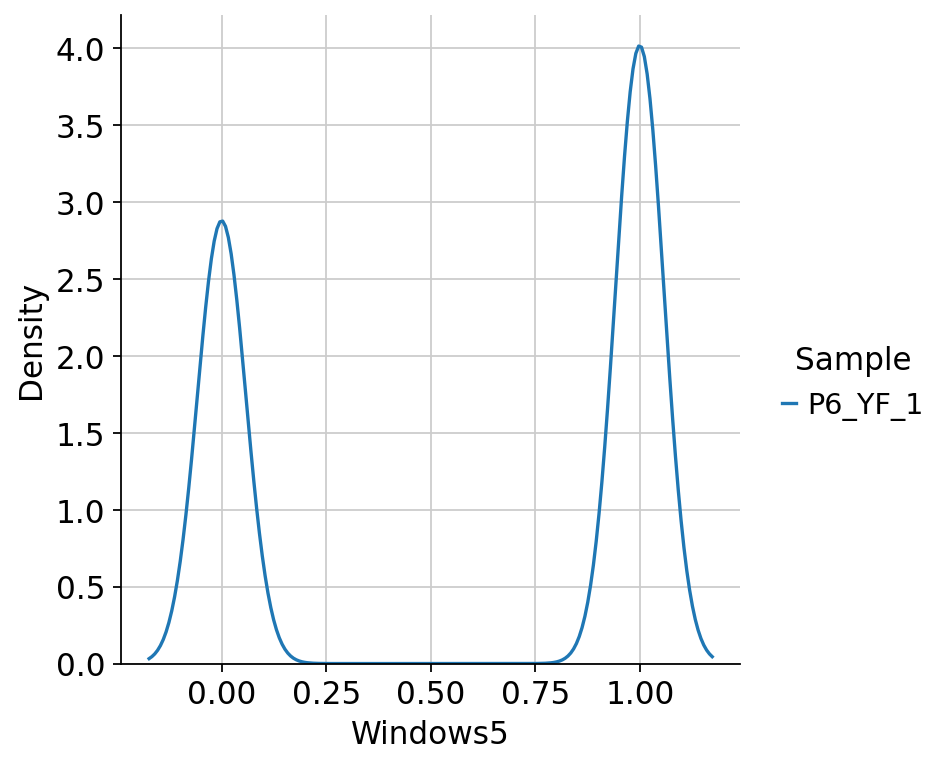

In [37]:
sns.displot(adata.obs, x="Windows5", hue="Sample", kind="kde")

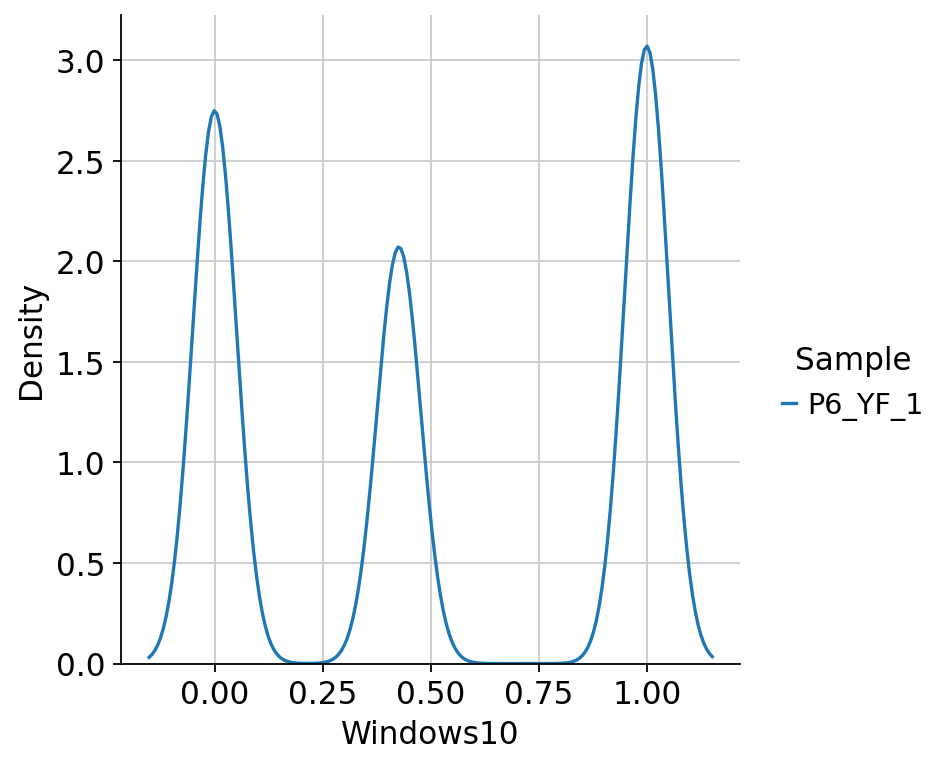

In [38]:
sns.displot(adata.obs, x="Windows10", hue="Sample", kind="kde")

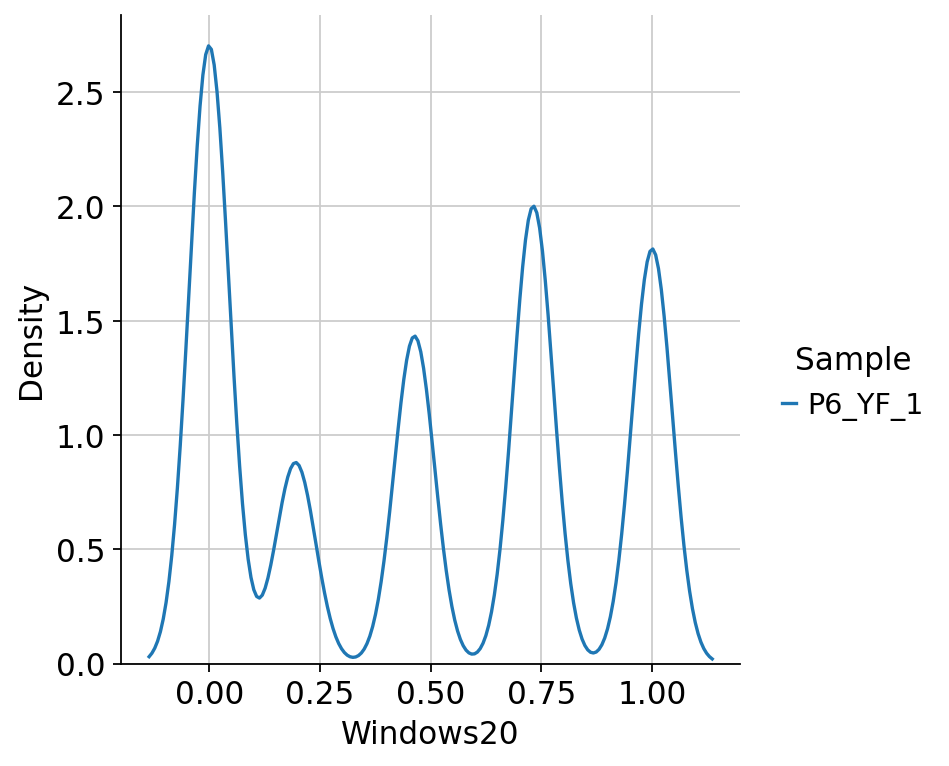

In [39]:
sns.displot(adata.obs, x="Windows20", hue="Sample", kind="kde")

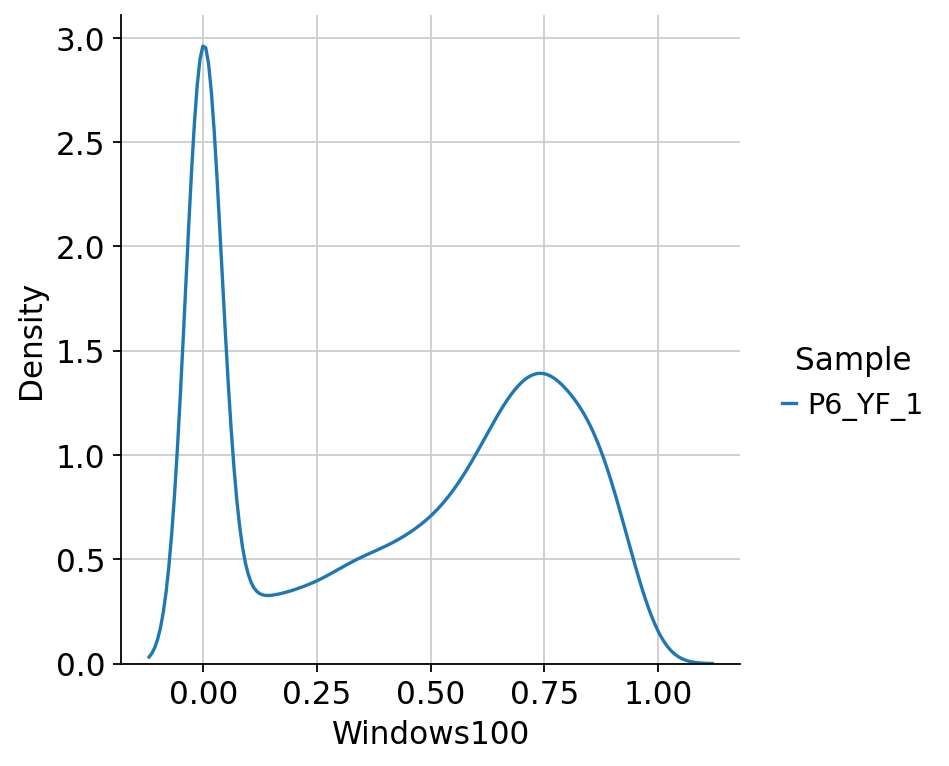

In [40]:
sns.displot(adata.obs, x="Windows100", hue="Sample", kind="kde")

In [41]:
from matplotlib.colors import LinearSegmentedColormap

colors = [(0,'#f5d1d1'),(0.25,'#ffadaa'),(0.5,'#ff8780'),(0.75,'#ff5d54'),(1,'#fb2323')]
cmap = LinearSegmentedColormap.from_list('custom_cmap',colors)

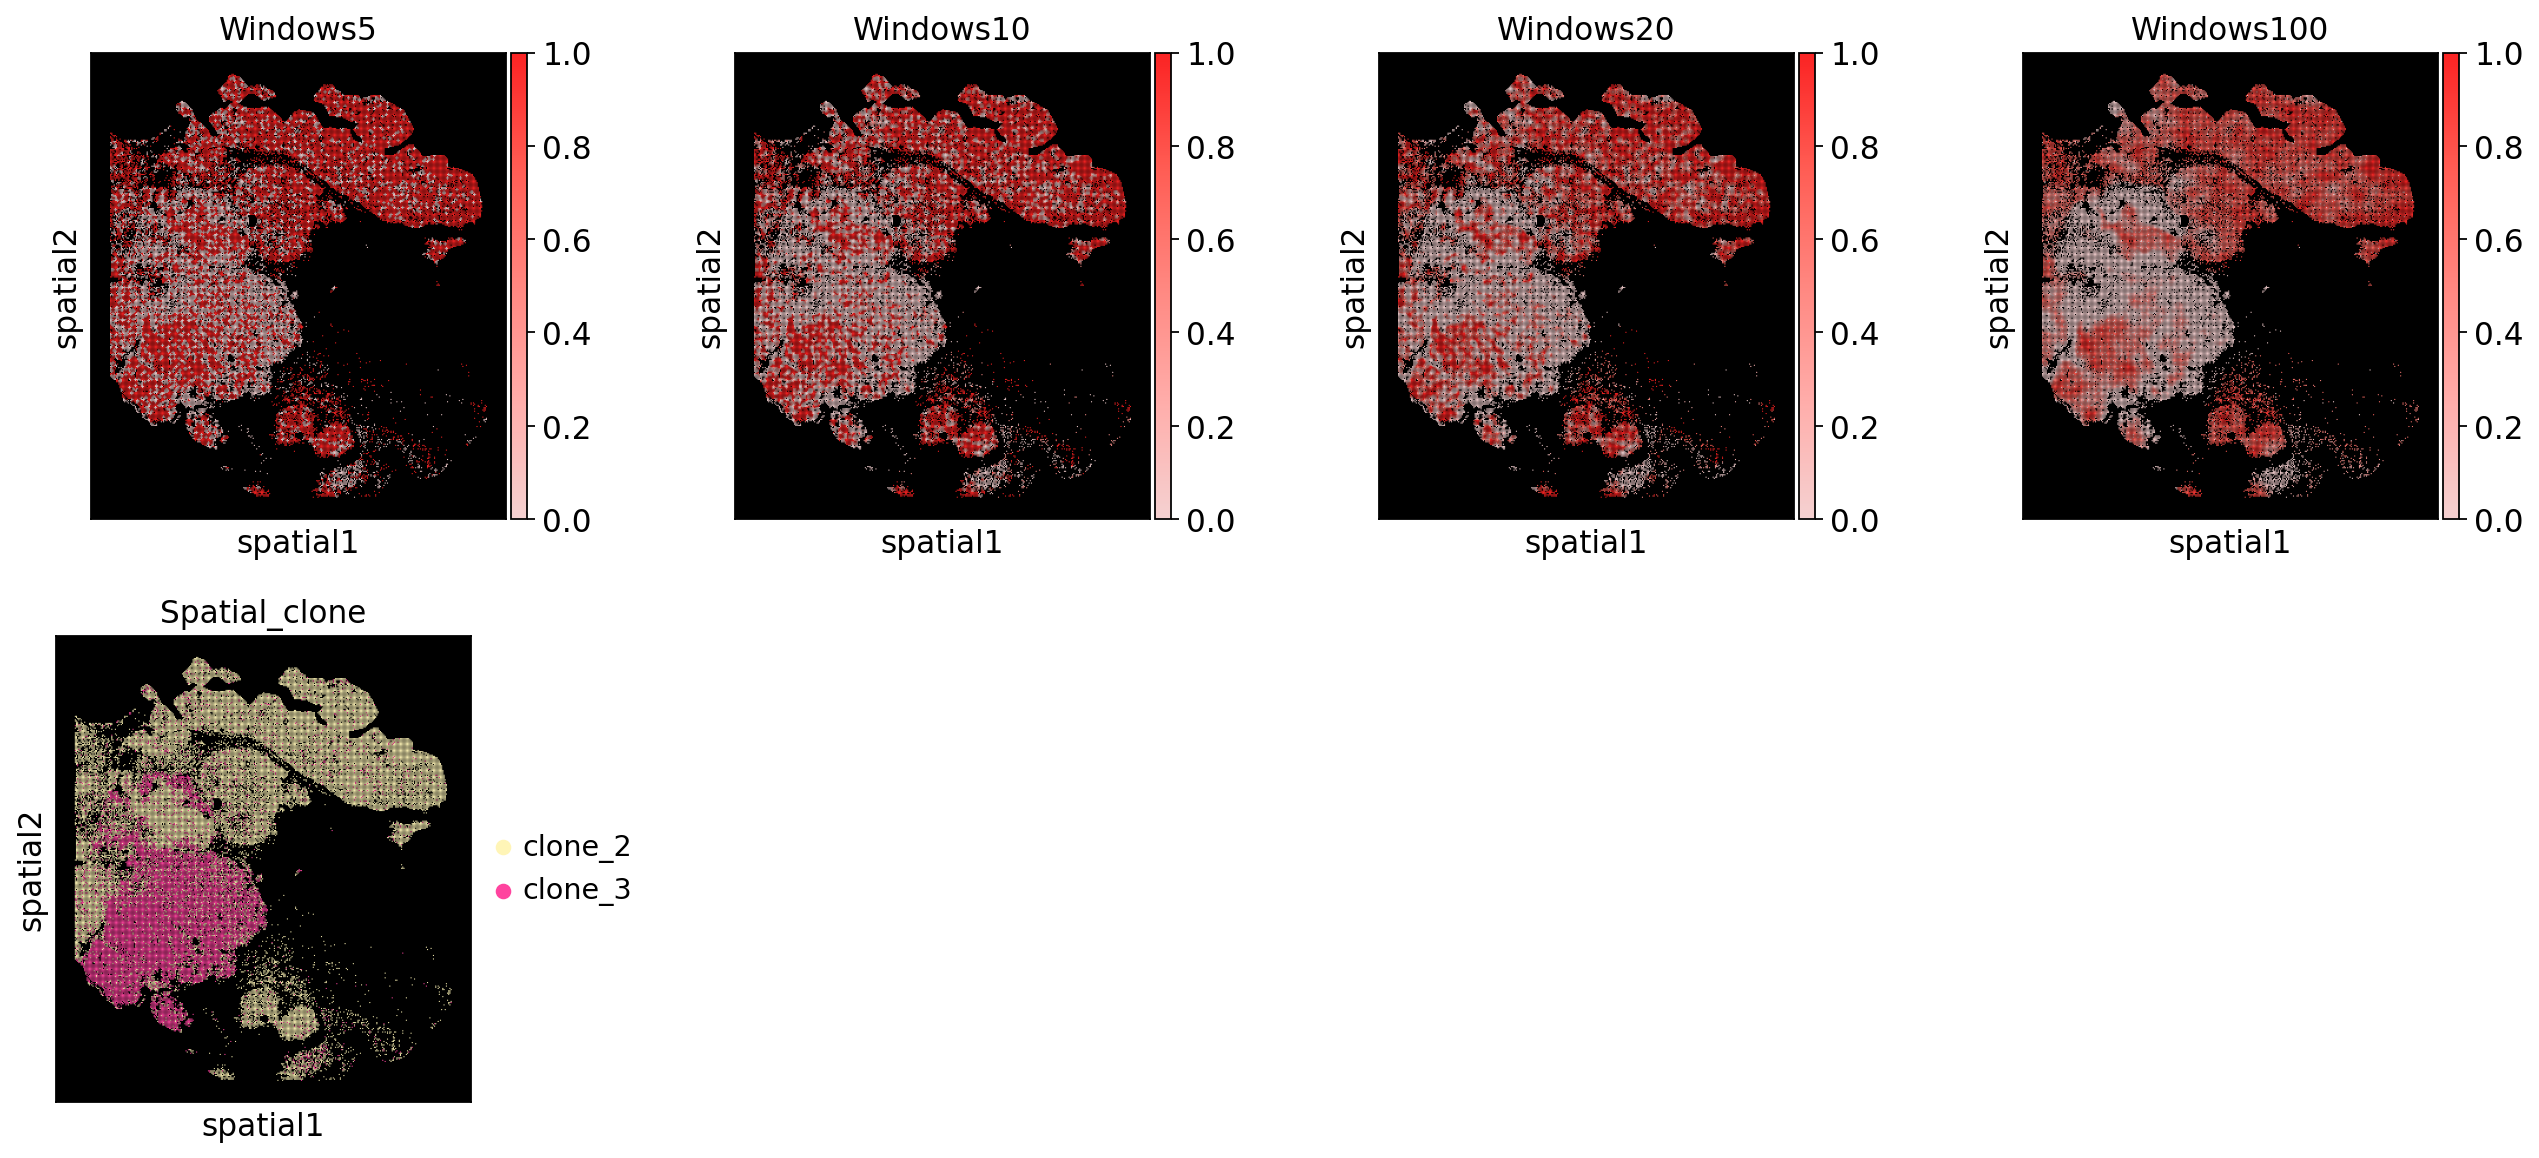

In [42]:
with mpl.rc_context({'axes.facecolor':'black'}):
    sc.pl.spatial(adata.copy(),
         color=['Windows5','Windows10','Windows20','Windows100','Spatial_clone'],
         # title=sample,
                  palette=['#FFF5B7','#FF449F','#005F99','#184D47'],
                 cmap=cmap,
                  save='_OV006_Ov_R_1_windows.pdf',
         spot_size=50)

In [43]:
adata.write_h5ad('./adata_with_coherence_windows5_10_20_100.h5ad')

In [44]:
adata.obs.to_csv('./adata_with_coherence_windows5_10_20_100.csv')